# INFORME FINAL: PRESENTACIÓN DEL PROYECTO
- Carga del dataset final (desde Kedro o CSV backup)
- Resultados de modelos supervisados (clasificación y regresión)
- Análisis no supervisado
- Comparación de métricas vs notebooks originales
- Visualizaciones clave para explicar resultados

In [6]:
# --- Imports ---
import os, json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, roc_auc_score

In [7]:
# 1️⃣ Cargar dataset final y métricas desde ejecución Kedro
try:
    from kedro.framework.session import KedroSession
    session = KedroSession.create("..")
    context = session.load_context()
    catalog = context.catalog
    print("Kedro cargado ✅")

    master_table = catalog.load("master_table")
    clf_metrics = catalog.load("classification_metrics")
    reg_metrics = catalog.load("regression_metrics")
except:
    print("⚠️ Kedro no disponible. Usando respaldo local...")
    base_path = Path("../data/07_model_output")
    master_table = pd.read_csv("../data/04_feature/engineered_dataset.csv")
    with open(base_path / "classification_metrics.json") as f:
        clf_metrics = json.load(f)
    with open(base_path / "regression_metrics.json") as f:
        reg_metrics = json.load(f)

print(f"✅ master_table: {master_table.shape}")

[11/28/25 16:10:03] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=328366;file://c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=510024;file://c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro_telemetry\plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

Kedro cargado ✅


[11/28/25 16:10:04] INFO     Loading data from master_table (CSVDataSet)...                     ]8;id=2767;file://c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=424338;file://c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from classification_metrics (JSONDataSet)...          ]8;id=765350;file://c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=378651;file://c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from regression_metrics (JSONDataSet)...              ]8;id=741304;file://c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=741725;file://c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

✅ master_table: (13760, 16)


In [8]:
# 2️⃣ Mostrar métricas principales de modelos
df_clf = pd.DataFrame([clf_metrics])
df_reg = pd.DataFrame([reg_metrics])

print("\n📘 Clasificación:")
display(df_clf)
print("\n📗 Regresión:")
display(df_reg)


📘 Clasificación:


,Modelo,Accuracy,Precision,Recall,F1,ROC_AUC,params
0,RandomForest (Clasificación),0.834593,0.826432,0.847093,0.836635,0.916127,"{'bootstrap': 'True', 'ccp_alpha': '0.0', 'cla..."



📗 Regresión:


,Modelo,MAE,MSE,RMSE,R2,params
0,RandomForestRegressor,5.000636,50.19808,7.08506,0.612154,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."


                    INFO     Loading data from rf_clf_model (PickleDataSet)...                  ]8;id=911098;file://c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=435788;file://c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

Modelo cargado desde Kedro ✅
🔎 Modelo entrenado con 3 características.


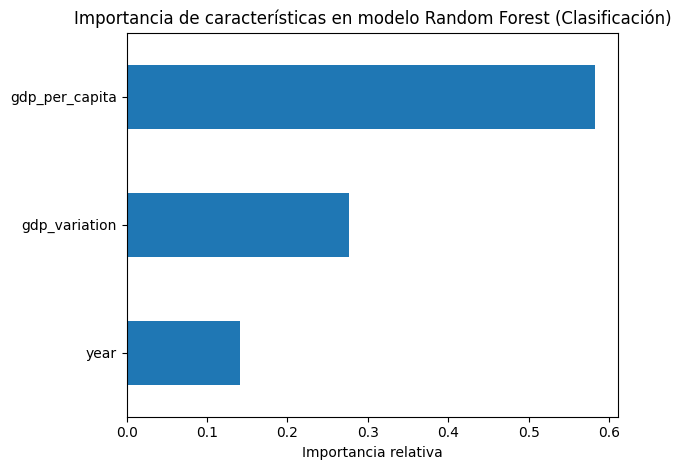

In [9]:
# --------------------------------------------------------------
# Visualización de importancia de variables (robusta)
# --------------------------------------------------------------
import joblib

try:
    rf_clf_model = catalog.load("rf_clf_model")
    print("Modelo cargado desde Kedro ✅")
except:
    print("⚠️ No se pudo cargar desde Kedro. Usando respaldo local...")
    rf_clf_model = joblib.load("../data/06_models/best_classification_model_RandomForest.pkl")

# Importancias
importances = rf_clf_model.feature_importances_

# Determinar los nombres de features (ajustar según el número real)
print(f"🔎 Modelo entrenado con {len(importances)} características.")
features = [
    "gdp_per_capita", 
    "gdp_variation", 
    "year"
]  # Ajusta esta lista a que tenga SOLO 3 si ese es el caso

# Validación
if len(importances) != len(features):
    features = [f"Feature {i+1}" for i in range(len(importances))]

# Graficar
pd.Series(importances, index=features).sort_values().plot(kind="barh")
plt.title("Importancia de características en modelo Random Forest (Clasificación)")
plt.xlabel("Importancia relativa")
plt.tight_layout()
plt.show()


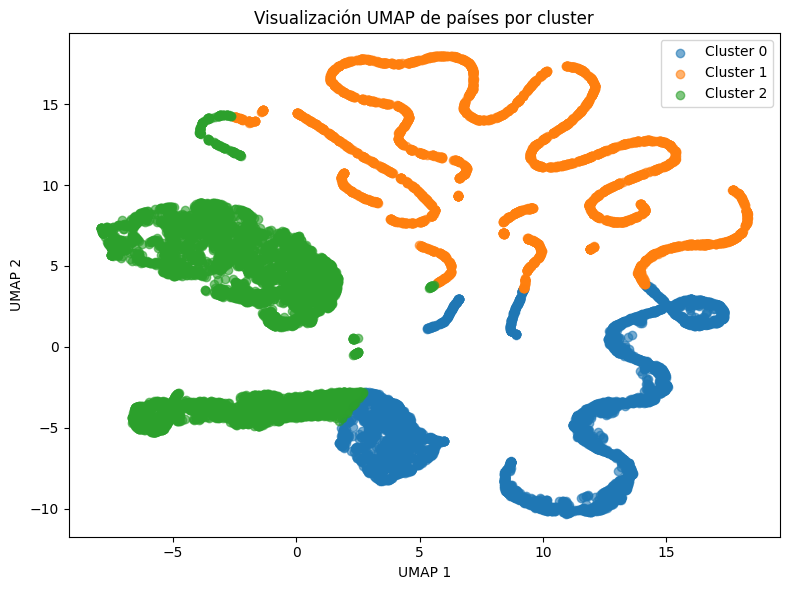

In [10]:
# --------------------------------------------------------------
# 4️⃣ Visualización 2D: Clusters con UMAP (auto-clustered)
# --------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Cargar UMAP embedding desde CSV
df_umap = pd.read_csv("../data/07_model_output/umap_embedding.csv")

# Generar clusters si no existen
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_umap["cluster"] = kmeans.fit_predict(df_umap)

# Graficar clusters
plt.figure(figsize=(8,6))
for c in range(n_clusters):
    subset = df_umap[df_umap["cluster"] == c]
    plt.scatter(subset.iloc[:,0], subset.iloc[:,1], label=f"Cluster {c}", alpha=0.6)

plt.title("Visualización UMAP de países por cluster")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.tight_layout()
plt.show()

